In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
df = pd.read_csv('./data/result.csv')
print(df.info())
print("------------------------------------")
print(df.head())
print(df.tail())
print("------------------------------------")
print(df.isnull().sum())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1792 entries, 0 to 1791
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   일시         1792 non-null   object 
 1   평균 수온(°C)  1792 non-null   float64
dtypes: float64(1), object(1)
memory usage: 28.1+ KB
None
------------------------------------
           일시  평균 수온(°C)
0  2019-01-01       14.4
1  2019-01-02       14.8
2  2019-01-03       15.1
3  2019-01-04       15.2
4  2019-01-05       15.2
              일시  평균 수온(°C)
1787  2023-12-27       15.5
1788  2023-12-28       15.2
1789  2023-12-29       15.3
1790  2023-12-30       14.4
1791  2023-12-31       14.3
------------------------------------
일시           0
평균 수온(°C)    0
dtype: int64
(1792, 2)


In [3]:
# converting column names from korean to english
df.rename(columns={'일시':'date', '평균 수온(°C)':'avg_temperature'}, inplace=True)

In [4]:
# time-related data indexing
df2 = df.set_index(['date'])
print(df2.head())
print("------------------------------------")
print(df2.info())

            avg_temperature
date                       
2019-01-01             14.4
2019-01-02             14.8
2019-01-03             15.1
2019-01-04             15.2
2019-01-05             15.2
------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 1792 entries, 2019-01-01 to 2023-12-31
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   avg_temperature  1792 non-null   float64
dtypes: float64(1)
memory usage: 28.0+ KB
None


<Axes: xlabel='date'>

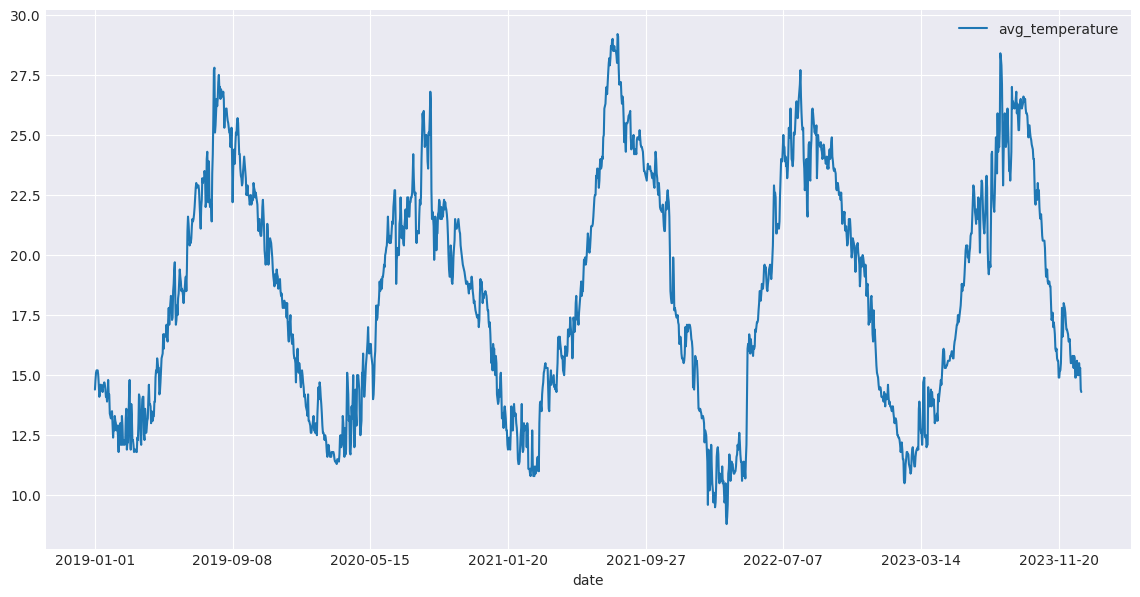

In [5]:
df2.plot(figsize=(14, 7))

주기성(cycle) 확인됨 => Non-Stationary

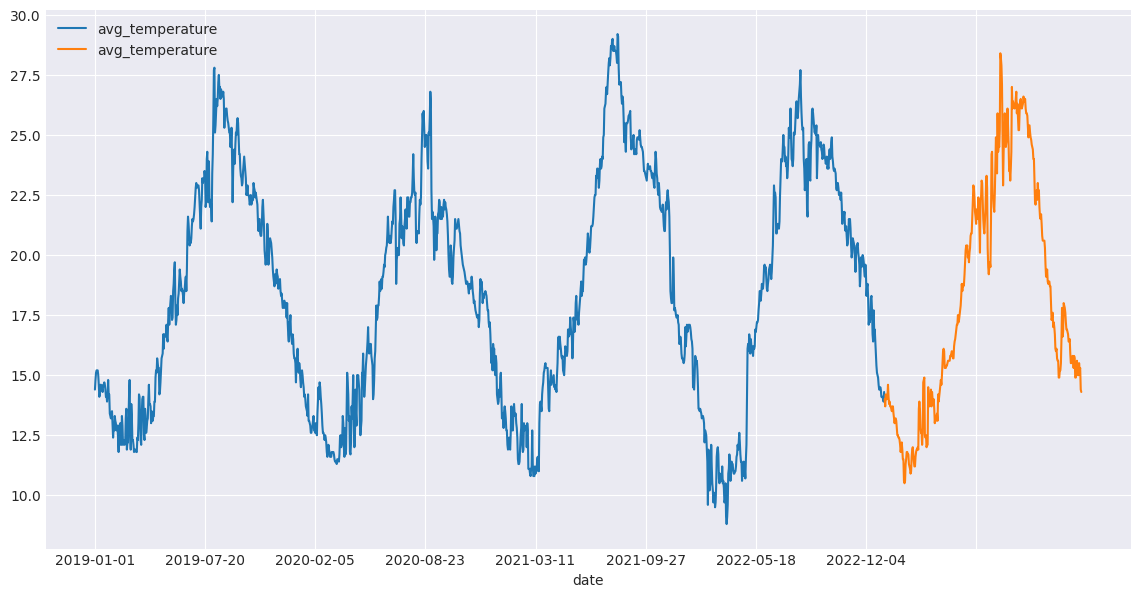

In [6]:
# train(80%) : test(20%)
tst_ratio = 0.2
split_tst_index = int(len(df2) * tst_ratio)
trn, tst = df2[:-split_tst_index], df2[-split_tst_index:]

# range(start, stop, step) 이용하여 test data의 index를 새로 할당
tst.index = range(len(trn), len(trn) + len(tst))
# print(tst.index)

ax = trn.plot(label='train', figsize=(14, 7))
tst.plot(label='test', ax=ax)
plt.legend()
plt.show()

# ARIMA

1. 자기상관함수 ACF(AutoCorrelation Function) / PACF(Partial ACF) 그리기
2. statsmodels 라이브러리의 adfuller 함수로 정상성 검정

ADF Statistic: -2.0660271477589403
p-value: 0.2583927779770129
Critical Values:
	1%: -3.4349279657922653
	5%: -2.863561857668172
	10%: -2.567846424153014


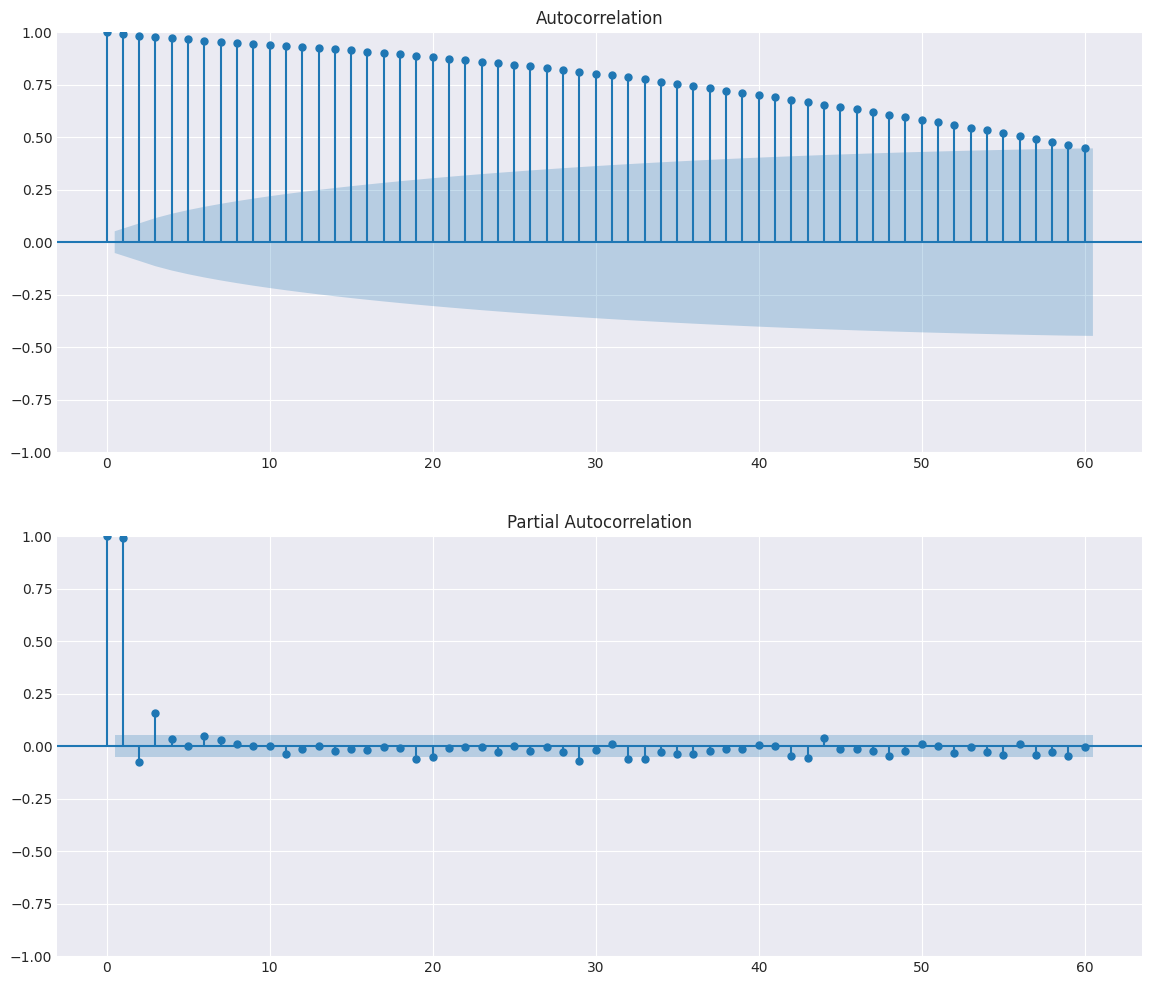

In [7]:
fig = plt.figure(figsize=(14, 12))
# 2x1 subplot grid의 1번째 subplot
ax1 = fig.add_subplot(211)
fig = plot_acf(trn.values.squeeze(), lags=60, ax=ax1)
# 2x1 subplot grid의 2번째 subplot
ax2 = fig.add_subplot(212)
fig = plot_pacf(trn.values.squeeze(), lags=60, ax=ax2)

# 정상성을 띄는 시계열 데이터인지 평가하기위해 Augmented Dickey-Fuller(ADF) 검정 수행
adf = adfuller(trn)
print('ADF Statistic: {}'.format(adf[0]))   # ADF 통계량
print('p-value: {}'.format(adf[1])) # p-value값이 낮을수록 정상성을 가짐
print('Critical Values:')           # 임계값 출력
for k, v in adf[4].items():
    print('\t{}: {}'.format(k, v))

위 그래프를 보면
- ACF: Die out. 지수적으로 서서히 감소, 소멸하는 sine함수 형태
- PACF: Cut off after lag p. p시차 이후 0으로 절단

### 차분(Differencing)하여 정상시계열 만들기

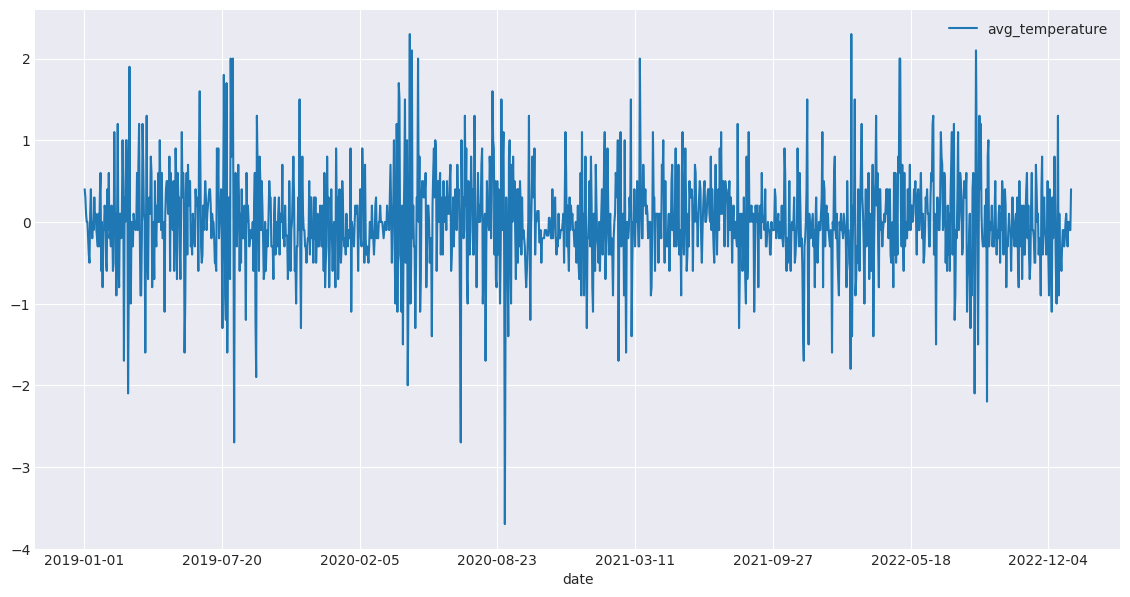

In [8]:
# 1차 차분(First Difference)
trn.diff(1).plot(label='Diff(1)', figsize=(14, 7))
plt.show()

ADF Statistic: -19.170464848906665
p-value: 0.0
Critical Values:
	1%: -3.4349376007389965
	5%: -2.8635661096787812
	10%: -2.567848688436159


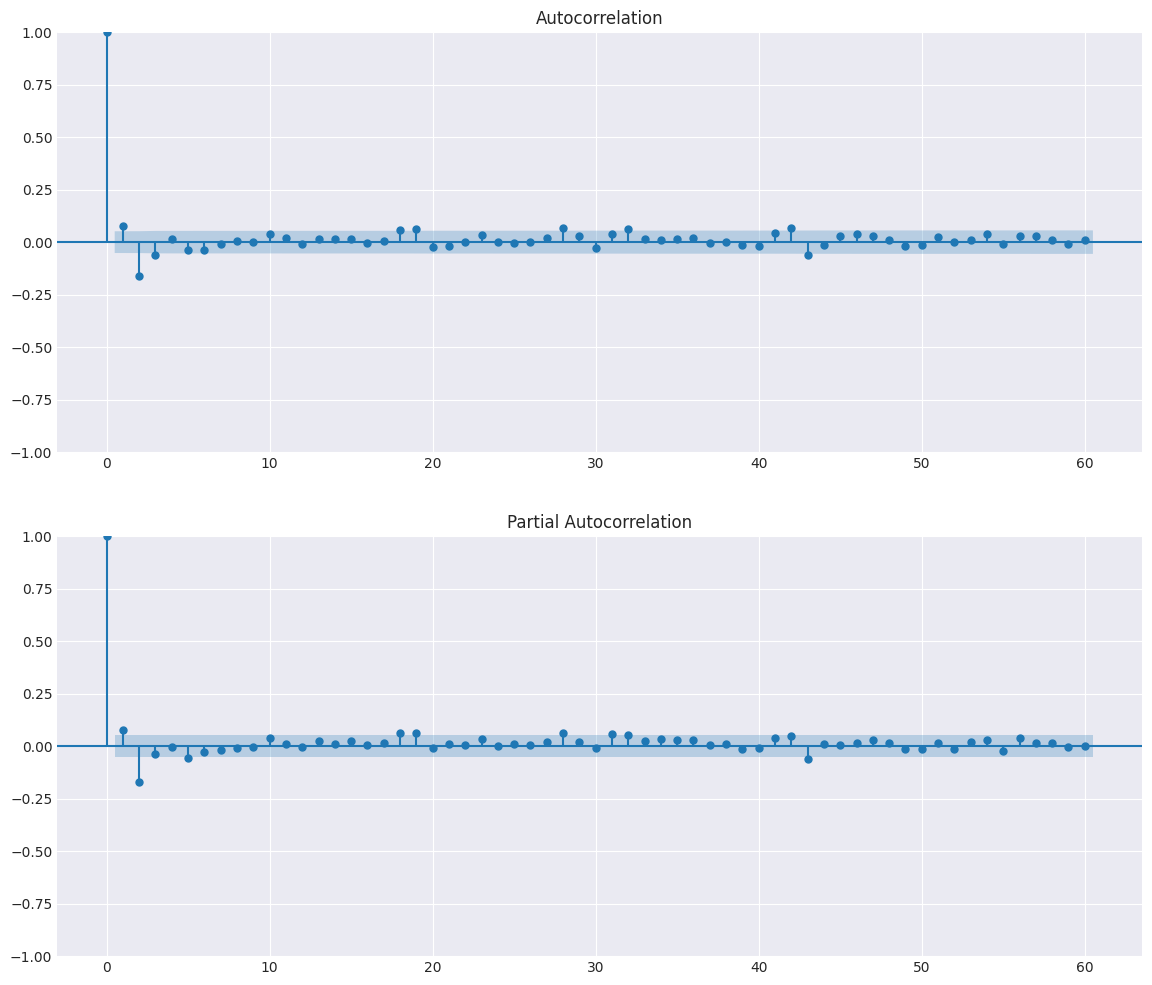

In [9]:
fig = plt.figure(figsize=(14, 12))

ax1 = fig.add_subplot(211)
fig = plot_acf(trn.diff(1).dropna().values.squeeze(), lags=60, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(trn.diff(1).dropna().values.squeeze(), lags=60, ax=ax2)

adf = adfuller(trn.diff(1).dropna())
print('ADF Statistic: {}'.format(adf[0]))
print('p-value: {}'.format(adf[1]))
print('Critical Values:')
for key, value in adf[4].items():
    print('\t{}: {}'.format(key, value))

1차 차분(First Difference) 후 그래프를 보면
- ACF: 불규칙. 정상성 확인. ACF(q, MA) = 4
- PACF: PACF(p, AR) = 3\
=> ARIMA(p, d, q) = 3, 1, 4 로 성능 평가하기

In [10]:
def mape(y_pred, y_true):
    return (np.abs(y_pred - y_true)/y_true).mean() * 100

def mae(y_pred, y_true):
    return np.abs(y_pred - y_true).mean()

In [11]:
trn2, tst2 = df2[:-split_tst_index], df2[-split_tst_index:]
arma_mod30 = ARIMA(trn2, order=(3, 1, 4)).fit() # AR(3)

/home/lje/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lje/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/lje/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [18]:
print(tst2.index)
print(len(tst2))

Index(['2023-01-07', '2023-01-08', '2023-01-09', '2023-01-10', '2023-01-11',
       '2023-01-12', '2023-01-13', '2023-01-14', '2023-01-15', '2023-01-16',
       ...
       '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25', '2023-12-26',
       '2023-12-27', '2023-12-28', '2023-12-29', '2023-12-30', '2023-12-31'],
      dtype='object', name='date', length=358)
358


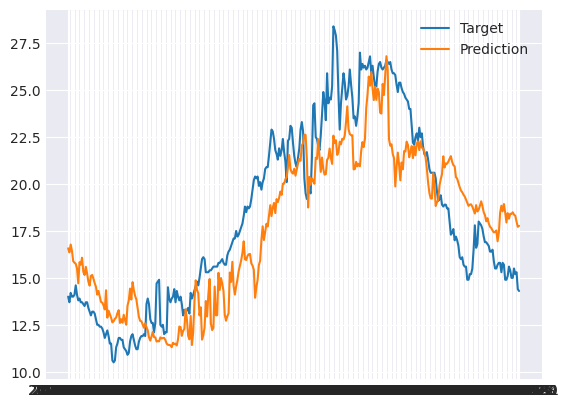

In [33]:
prd = arma_mod30.predict(len(tst2), len(tst2) + 357, dynamic=False)

plt.plot(tst2.index, tst2, label="Target")
plt.plot(tst2.index, prd, label="Prediction")
plt.legend()
plt.show()